**Рекуррентная нейронная сеть (RNN)**

**Рекуррентная нейронная сеть (RNN)** - это класс искусственных нейронных сетей, в которых узел может получать входы не только от других узлов и текущих входных данных но и выходы узлов, полученные при рассмотрении предыдущих входных данных последовательности.
* обмен вектором внутреннего сосотояния, полученного на предыдущем шаге, позволяет использовать информацию о предыдущих шагах, которые сеть уже обработала
* при рассмотрении всей последовательности веса каждого узла одни и те же при рассмотрении всех входных данных последовательности


* Такая архитектура сети позволяет обрабатывать серии событий во времени или последовательные пространственные цепочки произвольной размерности


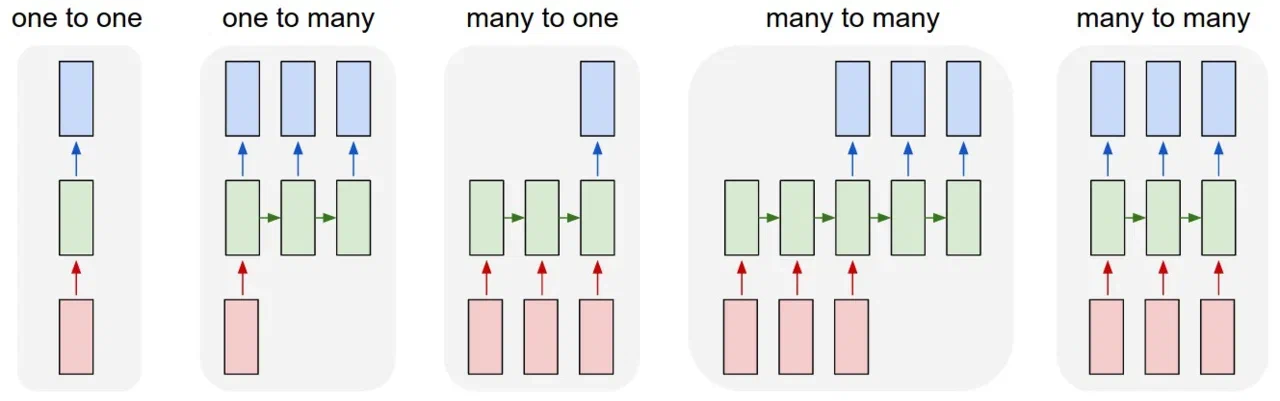

Трудность рекуррентной сети:
* если учитывать каждый шаг времени, то становится необходимым для каждого шага времени (последовательности) создавать свой слой нейронов, что создает серьёзные вычислительные сложности
* многослойные реализации вычислительно неустойчивы: в них как правило либо исчезают либо зашкаливают веса
* если ограничить расчёт фиксированным временным окном, то полученные модели не будут отражать долгосрочных трендов

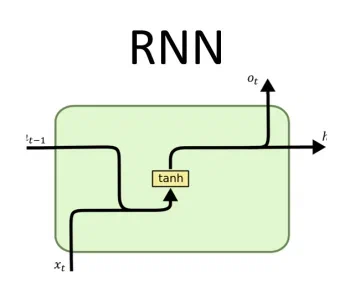


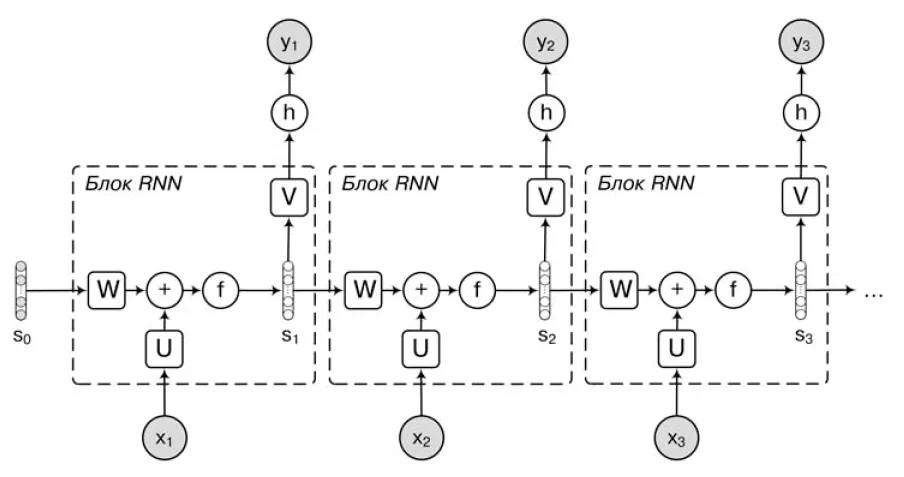

__Распространение ошибки в архитектуре RNN__

* В прямой нейронной сети ошибка на конкретном нейроне вычисляется как функция от ошибок нейронов, которые используют его выходное значение <em class="hn"></em> формируется ациклический графы вычислений:
**Прямой и обратный проход процедуры обучения многослойной ИНС**

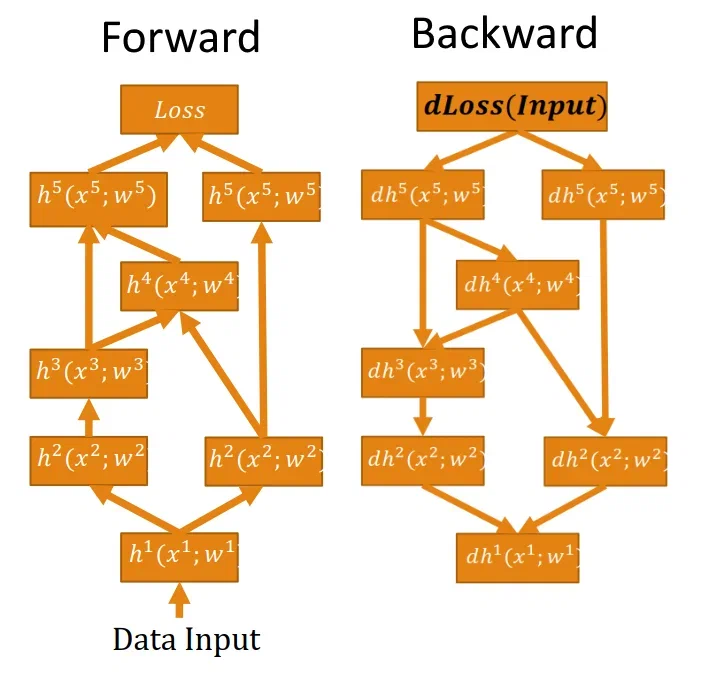


* В архитектуре RNN нейрон принимает в качестве входа результат вычисления в нем самом (через вектор состояния)
    * Важно понимать, что при этом петли в графе вычислений не образуется
    * Вычисления, которые делает рекуррентная сеть, можно развернуть обратно до начала обрабатываемой последовательности
    * Можно сказать, что на каждом шаге обрабатываемой последовательности сеть создает копии самой себя
**Распространение ошибок в узле RNN**

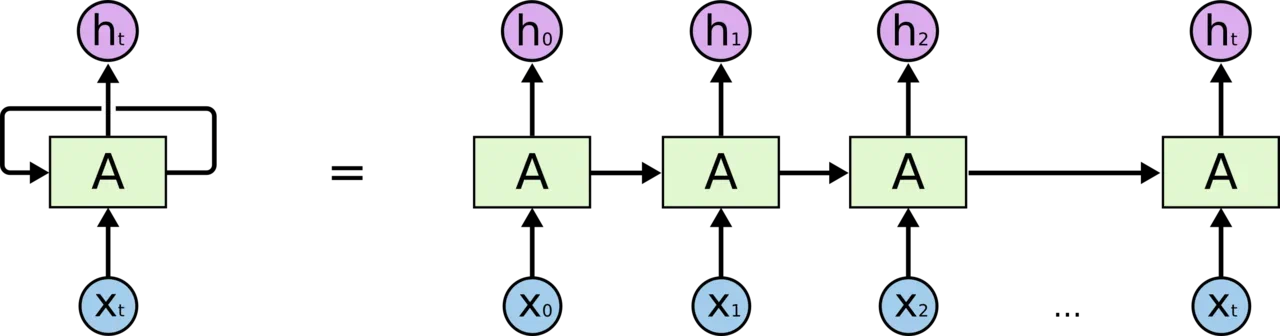

* И на каждом последовательности мы фактически обучаем глубокую нейронную сеть, в которой столько слоев, сколько элементов в последовательности на данный момент мы уже видели
* Рекуррентная сеть — разворчиватся вдоль элементов последовательности $1 \dotsc T$ в очень-очень многоуровневую обычную сеть, в которой одни и те же веса переиспользуются на каждом уровне.
    * <em class="pl"></em> Для хранения весов достаточно одной матрицы
    * <em class="pl"></em> Градиенты по весам не затухают до нуля сразу же (как это бывает в обычных глубких сетях)
    * <em class="mn"></em> Если матрица весов меняет норму вектора градиента при проходе через один «слой» обратного распространения, то при проходе через T слоев эта норма изменяется экспоненциально (т.к. веса матрицы одни и те же) это приводит:
        * к __"взрыву градиентов"__ (exploding gradients), если матрица заметно увеличивает норму вектора градиента
        * к экспоненациональному затуханию градиентов (Vanishing gradients), если матрица заметно уменьшает норму вектора градиента

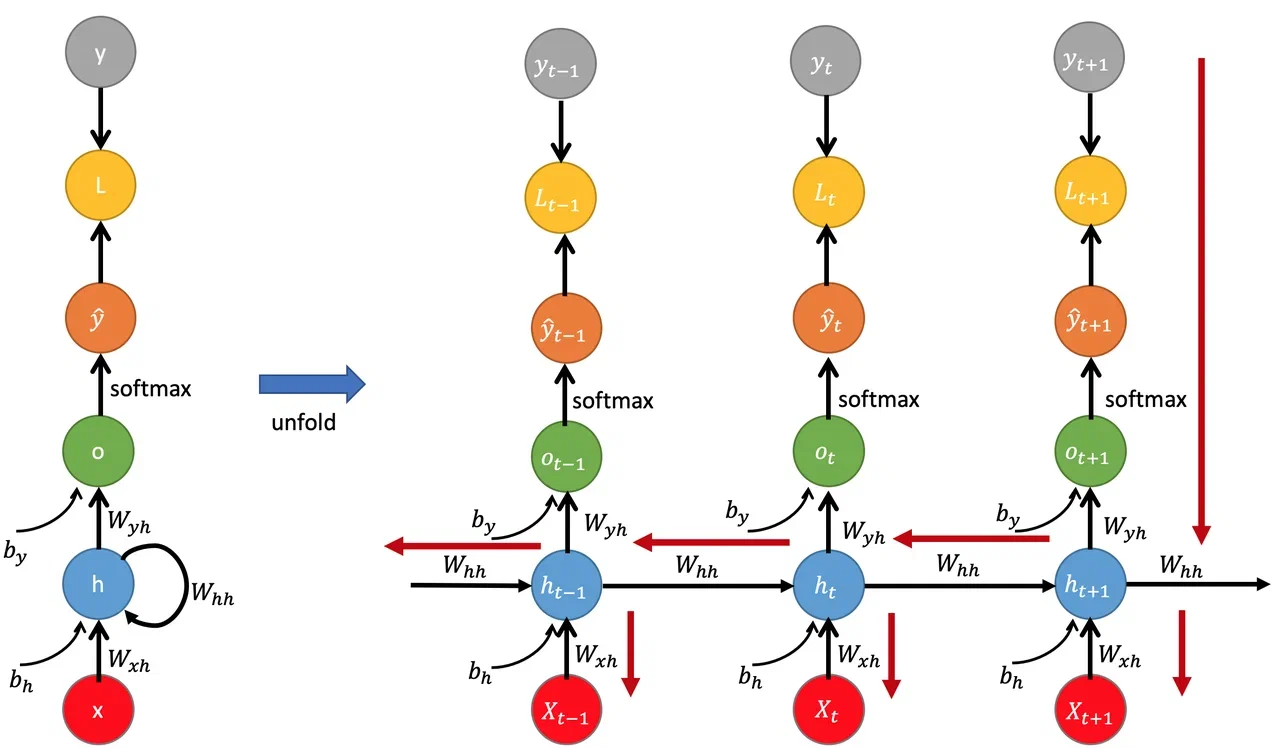<center>         


In [ ]:
from torch import nn
import torch


# Simple RNNcell without a bias and batch support
class SimplifiedRNNCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        # Init weight matrix, for simplicity omit bias
        self.W_hx = (
            torch.randn(input_size, hidden_size) * 0.0001
        )  # hidden_size == number of neurons
        self.W_hh = (
            torch.randn(hidden_size, hidden_size) * 0.0001
        )  # naive initialization
        self.h0 = torch.zeros((hidden_size))  # Initial hidden state

    def forward(self, x, h=None):  # Without a batch dimension
        if h is None:
            h = self.h0
        h = torch.tanh(x @ self.W_hx + h @ self.W_hh)
        return h


simple_rnn_cell = SimplifiedRNNCell(input_size=3, hidden_size=2)
dummy_sequence = torch.randn(1, 3)
h = simple_rnn_cell(dummy_sequence[0])  # No batch

print(f"Out = h\n{h.shape} \n{h}")

Out = h
torch.Size([2]) 
tensor([-7.8291e-05,  9.6784e-05])


## 1. Классификация фамилий (RNN)

Датасет: https://disk.yandex.ru/d/frNchuaBQVLxyA?w=1

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import accuracy_score

surnames = pd.read_csv("/kaggle/input/1221312/surnames.csv")
surnames["surname"] = surnames["surname"].str.lower()

encoder = LabelEncoder().fit(surnames["nationality"]) # применить label encoding
y = encoder.transform(surnames["nationality"])

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

In [ ]:
class Vocab:
    def __init__(self, data):
        self.max_seq_len = data.str.len().max()
        self.tokens = set()
        for item in data:
            self.tokens.update(item)
        self.idx_to_token = dict(enumerate(self.tokens, 1))
        self.idx_to_token[0] = "<PAD>"
        self.token_to_idx = {token: idx for idx, token in self.idx_to_token.items()}
        self.vocab_len = len(self.idx_to_token)

In [ ]:
class SurnamesDataset(Dataset):
    def __init__(self, X, y, vocab: Vocab):
        self.X = X
        self.y = torch.LongTensor(y)
        self.vocab = vocab


    def vectorize(self, surname):
        '''
        Генерирует представление фамилии surname в при помощи бинарного кодирования (см. 1.2)
        '''
        surname_t = torch.zeros(self.vocab.max_seq_len).type(torch.long)
        for i, token in enumerate(surname):
            surname_t[i] = self.vocab.token_to_idx[token]
        return surname_t


    def __len__(self):
        return len(self.X)


    def __getitem__(self, idx):
        return self.vectorize(self.X.iloc[idx]), self.y[idx]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(surnames.surname, y, test_size=0.2)

vocab = Vocab(surnames["surname"])
trainset = SurnamesDataset(X_train, y_train, vocab)
testset = SurnamesDataset(X_test, y_test, vocab)

trainloader = DataLoader(trainset, batch_size=32)
testloader = DataLoader(trainset, batch_size=32)

Используя класс nn.RNNCell (абстракцию для отдельного временного шага RNN), реализуйте простейшую рекуррентную сеть Элмана в виде класса RNN. Используя созданный класс RNN, решите задачу классификации фамилий.

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.rnncell = nn.RNNCell(input_size=input_size, hidden_size=hidden_size)


    def forward(self, x, h=None):
        '''
        x.shape = (batch_size, seq_len, feature_size) - тензор входных данных
        h.shape = (batch_size, hidden_size) - тензор со скрытым состоянием RNN
        '''
        seq_len = x.size(1)
        batch_size = x.size(0)
        # инициализация тензора скрытых состояний
        if not h:
            h = torch.zeros(batch_size, self.hidden_size)
        hs = torch.zeros(batch_size, seq_len, self.hidden_size)

        # проход по каждому элементу последовательностей s в батче и обновление скрытого состояния
        # h = RNNCell(s_t, h)
        for i in range(seq_len):
            h = self.rnncell(x[:,i,:], h)
            hs[:,i,:] = h

        # вернуть тензор всех наблюдавшихся скрытых состояний размера (batch_size, seq_len, hidden_size)
        # и тензор скрытых состояний в последний момент времени
        return h, hs

In [ ]:
class MyModel(nn.Module):
    def __init__(self, input_size, hidden_size, vocab_len, pad_idx, num_classes):
        super(MyModel, self).__init__()
        self.rnncell = RNN(input_size=input_size, hidden_size=hidden_size)
        self.emb = nn.Embedding(
            num_embeddings=vocab_len,
            embedding_dim=input_size,
            padding_idx=pad_idx
        )
        self.fc = nn.Linear(in_features=hidden_size, out_features=num_classes)


    def forward(self, x):
        x = self.emb(x)
        x, hs = self.rnncell(x)
        x = self.fc(x)

        return x

In [ ]:
num_classes = len(np.unique(y))

model = MyModel(
    input_size=64,
    hidden_size=16,
    vocab_len=vocab.vocab_len,
    pad_idx=0,
    num_classes=num_classes
)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def model_train(model, optimizer, criterion, train_loader, test_loader, n_epochs=10, epoch_step=5):
    for epoch in range(n_epochs):
        y_pred = torch.empty(0)
        y_true = torch.empty(0, dtype=torch.long)
        model.train()

        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                y_true = torch.cat((y_true, y_batch))
                y_pred = torch.cat((y_pred, predictions))

        with torch.no_grad():
            train_acc = accuracy_score(y_true, y_pred.argmax(dim=1)).item()
            train_loss = criterion(y_pred, y_true).item()

        model.eval()
        with torch.no_grad():
            y_pred = torch.empty(0)
            y_true = torch.empty(0, dtype=torch.long)
            for X_batch, y_batch in testloader:
                predictions = model(X_batch)
                y_true = torch.cat((y_true, y_batch))
                y_pred = torch.cat((y_pred, predictions))
            val_acc = accuracy_score(y_true, y_pred.argmax(dim=1)).item()
            val_loss = criterion(y_pred, y_true).item()

            if epoch % epoch_step == 0:
                print(f'#{epoch} Training loss: {train_loss:.4f} training_acc:\
 {train_acc:.4f} val_loss: {val_loss:.4f} val_acc: {val_acc:.4f}')
    return y_true, y_pred.argmax(dim=1)

model_train(model, optimizer, criterion, trainloader, testloader, n_epochs=51, epoch_step=5)

#0 Training loss: 2.3300 training_acc: 0.2683 val_loss: 2.2116 val_acc: 0.2689
#5 Training loss: 1.8013 training_acc: 0.4808 val_loss: 1.7533 val_acc: 0.5115
#10 Training loss: 1.5490 training_acc: 0.5796 val_loss: 1.5211 val_acc: 0.5908
#15 Training loss: 1.4755 training_acc: 0.6021 val_loss: 1.4536 val_acc: 0.6068
#20 Training loss: 1.4384 training_acc: 0.6130 val_loss: 1.4163 val_acc: 0.6223
#25 Training loss: 1.4097 training_acc: 0.6210 val_loss: 1.3860 val_acc: 0.6299
#30 Training loss: 1.3856 training_acc: 0.6296 val_loss: 1.3621 val_acc: 0.6389
#35 Training loss: 1.3594 training_acc: 0.6389 val_loss: 1.3480 val_acc: 0.6401
#40 Training loss: 1.3477 training_acc: 0.6430 val_loss: 1.3265 val_acc: 0.6495
#45 Training loss: 1.3357 training_acc: 0.6467 val_loss: 1.3172 val_acc: 0.6511
#50 Training loss: 1.3271 training_acc: 0.6472 val_loss: 1.3098 val_acc: 0.6532


(tensor([10,  4,  6,  ..., 14, 14,  2]),
 tensor([ 0,  4,  4,  ..., 14, 14, 14]))

In [ ]:
def predict_surname(surname):
    surname = surname.lower()
    return encoder.inverse_transform(model(trainset.vectorize(surname).view(1,-1)).argmax().view(-1))[0]

In [ ]:
predict_surname("Snow")

'English'

Замените модуль `RNN` на модули `nn.RNN`, `nn.LSTM` и `nn.GRU`. Какая из моделей покажет наибольшую эффективность?

**RNN**

RNN (Recurrent Neural Network) в отличие от свёрточных нейронных сетей, которые обрабатывают данные блоками, RNN оперирует с данными пошагово и сохраняет информацию о предыдущих шагах.

Однако обычные RNN также имеют свои ограничения. Они сталкиваются с проблемой исчезающего или взрывающегося градиента, когда влияние дальних шагов на текущее состояние сети затухает или взрывается. Это затрудняет обучение RNN на длинных последовательностях, особенно когда важная информация находится в удалённых шагах.

In [ ]:
class MyModel(nn.Module):
    def __init__(self, input_size, hidden_size, vocab_len, pad_idx, num_classes):
        super(MyModel, self).__init__()
        self.rnncell = nn.RNN(input_size, hidden_size, batch_first=True)
        self.emb = nn.Embedding(
            num_embeddings=vocab_len,
            embedding_dim=input_size,
            padding_idx=pad_idx
        )
        self.fc = nn.Linear(in_features=hidden_size, out_features=num_classes)


    def forward(self, x):
        x = self.emb(x)
        output, h_n = self.rnncell(x)
        x = self.fc(output[:,-1,:])
        return x


model = MyModel(
    input_size=64,
    hidden_size=16,
    vocab_len=vocab.vocab_len,
    pad_idx=0,
    num_classes=num_classes
)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model_train(model, optimizer, criterion, trainloader, testloader, n_epochs=51, epoch_step=5)

#0 Training loss: 2.3782 training_acc: 0.2232 val_loss: 2.2181 val_acc: 0.2691
#5 Training loss: 1.8668 training_acc: 0.4597 val_loss: 1.8198 val_acc: 0.5172
#10 Training loss: 1.6504 training_acc: 0.5511 val_loss: 1.6545 val_acc: 0.5388
#15 Training loss: 1.5905 training_acc: 0.5667 val_loss: 1.5713 val_acc: 0.5719
#20 Training loss: 1.5680 training_acc: 0.5661 val_loss: 1.5420 val_acc: 0.5750
#25 Training loss: 1.5523 training_acc: 0.5715 val_loss: 1.5468 val_acc: 0.5734
#30 Training loss: 1.5239 training_acc: 0.5756 val_loss: 1.5759 val_acc: 0.5413
#35 Training loss: 1.5773 training_acc: 0.5528 val_loss: 1.5347 val_acc: 0.5650
#40 Training loss: 1.4831 training_acc: 0.5894 val_loss: 1.4751 val_acc: 0.5895
#45 Training loss: 1.5122 training_acc: 0.5665 val_loss: 1.4965 val_acc: 0.5724
#50 Training loss: 1.4796 training_acc: 0.5928 val_loss: 1.4866 val_acc: 0.5881


(tensor([10,  4,  6,  ..., 14, 14,  2]),
 tensor([10,  4,  4,  ..., 14, 14, 14]))

In [ ]:
predict_surname("Snow")

'English'

**LSTM**

LSTM (Long Short-Term Memory)

* обычные рекуррентные сети очень плохо справляются с ситуациями, когда нужно что-то «запомнить» надолго: влияние скрытого состояния или входа с шага t на последующие состояния рекуррентной сети экспоненциально затухает
* LSTM хорошо приспособлена к обучению на задачах классификации, обработки и прогнозирования временных рядов в случаях, когда важные события разделены временными лагами с неопределённой продолжительностью и границами

* вместо одного-единственного числа, на которое влияют все последующие состояния, используется специального вида ячейка моделирующая "долгую память"
    * LSTM моделирует процессы записи и чтения из этой "ячейки памяти"
    * у ячейки не один набор весов, как у обычного нейрона, а сразу несколько

В LSTM есть три основных вида узлов, которые называются гейтами:
* входной (input gate)
* забывающий (forget gate)
* выходной (output gate)
* рекуррентная ячейка со скрытым состоянием

In [ ]:
class MyModel(nn.Module):
    def __init__(self, input_size, hidden_size, vocab_len, pad_idx, num_classes):
        super(MyModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.emb = nn.Embedding(
            num_embeddings=vocab_len,
            embedding_dim=input_size,
            padding_idx=pad_idx
        )
        self.fc = nn.Linear(in_features=hidden_size, out_features=num_classes)


    def forward(self, x):
        embedded = self.emb(x)
        output, (h_n, c_n) = self.lstm(embedded)
        x = self.fc(output[:, -1, :])
        return x


model = MyModel(
    input_size=64,
    hidden_size=16,
    vocab_len=vocab.vocab_len,
    pad_idx=0,
    num_classes=num_classes
)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model_train(model, optimizer, criterion, trainloader, testloader, n_epochs=51, epoch_step=5)

#0 Training loss: 2.3509 training_acc: 0.2671 val_loss: 2.1042 val_acc: 0.4014
#5 Training loss: 1.4548 training_acc: 0.6130 val_loss: 1.4217 val_acc: 0.6270
#10 Training loss: 1.2764 training_acc: 0.6590 val_loss: 1.2517 val_acc: 0.6633
#15 Training loss: 1.1857 training_acc: 0.6759 val_loss: 1.1740 val_acc: 0.6751
#20 Training loss: 1.1266 training_acc: 0.6865 val_loss: 1.1318 val_acc: 0.6811
#25 Training loss: 1.0794 training_acc: 0.6992 val_loss: 1.0983 val_acc: 0.6890
#30 Training loss: 1.0419 training_acc: 0.7064 val_loss: 1.0333 val_acc: 0.7096
#35 Training loss: 1.0037 training_acc: 0.7184 val_loss: 0.9885 val_acc: 0.7198
#40 Training loss: 0.9873 training_acc: 0.7177 val_loss: 0.9990 val_acc: 0.7156
#45 Training loss: 0.9632 training_acc: 0.7240 val_loss: 0.9688 val_acc: 0.7224
#50 Training loss: 0.9497 training_acc: 0.7283 val_loss: 0.9450 val_acc: 0.7269


(tensor([10,  4,  6,  ..., 14, 14,  2]),
 tensor([10,  4,  0,  ..., 14, 14, 14]))

In [ ]:
predict_surname("Snow")

'German'

**GRU**

GRU (Gated Recurrent Unit) обладает похожей архитектурой на LSTM, но имеет меньше параметров и более простую структуру, также решает проблему затухания градиента, что позволяет ему эффективнее учитывать долгосрочные зависимости в последовательностях данных.

Главное преимущество GRU заключается в том, что он объединяет состояние скрытого слоя и "ячейку памяти" LSTM в единственной сущности, называемой "состоянием скрытого узла". Это позволяет модели GRU работать быстрее и занимать меньше места по сравнению с LSTM.

В GRU также присутствуют два гейта:
* сброс (reset gate): определяет, какая информация из предыдущих состояний должна быть проигнорирована при обновлении состояния
* обновление (update gate): определяет, какая информация из текущего входа и предыдущего состояния должна быть передана в следующее скрытое состояние

In [ ]:
class MyModel(nn.Module):
    def __init__(self, input_size, hidden_size, vocab_len, pad_idx, num_classes):
        super(MyModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.emb = nn.Embedding(
            num_embeddings=vocab_len,
            embedding_dim=input_size,
            padding_idx=pad_idx
        )
        self.fc = nn.Linear(in_features=hidden_size, out_features=num_classes)


    def forward(self, x):
        embedded = self.emb(x)
        output, h_n = self.gru(embedded)
        x = self.fc(output[:, -1, :])
        return x


model = MyModel(
    input_size=64,
    hidden_size=16,
    vocab_len=vocab.vocab_len,
    pad_idx=0,
    num_classes=num_classes
)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model_train(model, optimizer, criterion, trainloader, testloader, n_epochs=51, epoch_step=5)

#0 Training loss: 2.3216 training_acc: 0.2896 val_loss: 2.0364 val_acc: 0.4032
#5 Training loss: 1.3443 training_acc: 0.6323 val_loss: 1.3056 val_acc: 0.6461
#10 Training loss: 1.1785 training_acc: 0.6741 val_loss: 1.1599 val_acc: 0.6799
#15 Training loss: 1.1000 training_acc: 0.6976 val_loss: 1.0901 val_acc: 0.6989
#20 Training loss: 1.0484 training_acc: 0.7066 val_loss: 1.0378 val_acc: 0.7082
#25 Training loss: 1.0114 training_acc: 0.7139 val_loss: 1.0056 val_acc: 0.7154
#30 Training loss: 0.9810 training_acc: 0.7205 val_loss: 0.9700 val_acc: 0.7254
#35 Training loss: 0.9540 training_acc: 0.7286 val_loss: 0.9447 val_acc: 0.7316
#40 Training loss: 0.9274 training_acc: 0.7352 val_loss: 0.9200 val_acc: 0.7365
#45 Training loss: 0.9257 training_acc: 0.7316 val_loss: 0.9234 val_acc: 0.7353
#50 Training loss: 0.9058 training_acc: 0.7358 val_loss: 0.8937 val_acc: 0.7398


(tensor([10,  4,  6,  ..., 14, 14,  2]),
 tensor([10,  4,  1,  ..., 14, 14, 14]))

In [ ]:
predict_surname("Snow")

'English'